## Libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, classification_report, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
# from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from utils import plot_histograms,plot_bar, plot_bars, print_metrics
from utils import plot_target_vs_num_feature, binary_plot_count, plot_ROC_curve
import warnings


import pickle
warnings.filterwarnings('ignore')

## 1. Data

In [36]:
filename = 'data/archive.zip'

In [37]:
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('data')

In [38]:
credit_data = pd.read_csv("data/german_credit_data.csv", index_col=0)

In [39]:
credit_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## 2. EDA (Exploratory of Data Analysis)

### 2.1. Data preparation

In [40]:
credit_data.info();

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


#### Checking missing values

In [41]:
results_missing_values = credit_data.isnull().sum()/len(credit_data)*100

In [42]:
for variable in results_missing_values.index:
    missing_percentage = results_missing_values[results_missing_values.index==variable].values.item()
    print(f"{variable} : {missing_percentage}%")

Age : 0.0%
Sex : 0.0%
Job : 0.0%
Housing : 0.0%
Saving accounts : 18.3%
Checking account : 39.4%
Credit amount : 0.0%
Duration : 0.0%
Purpose : 0.0%
Risk : 0.0%


### Type of credit risk distribution

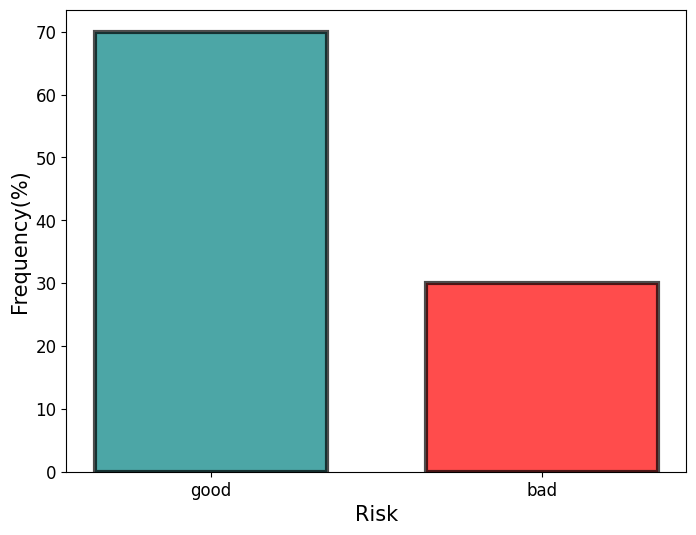

In [43]:
plot_bar(credit_data, variable="Risk", modalities_colors=["teal", "red"])

### Visualize numerical variables

In [44]:
numerical_vars = [col for col in credit_data.columns if credit_data[col].dtypes != "O" ]
numerical_vars.remove("Job")

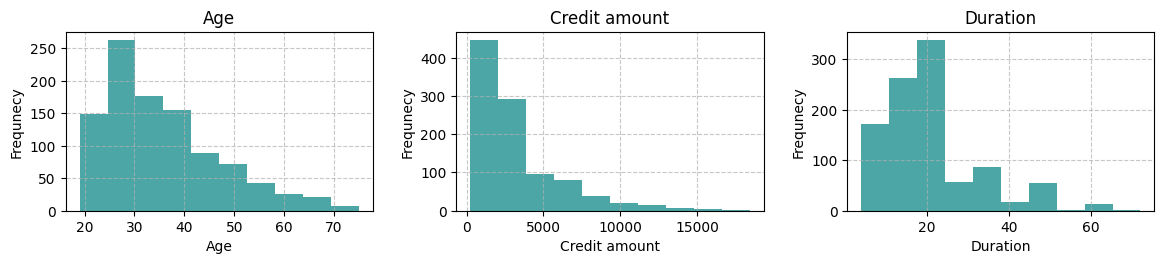

In [45]:
plot_histograms(credit_data, numerical_vars, plots_per_row =3)

### Visualize categorical feature

#### Job

In [46]:
modalities_names = ["unskilled and non-resident", "unskilled and resident", "skilled", "highly skilled"]

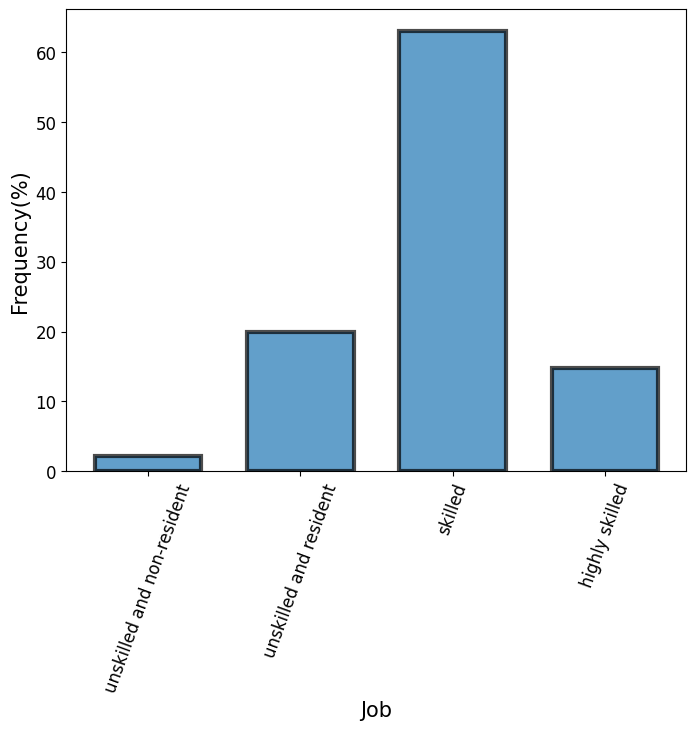

In [47]:
plot_bar(credit_data, "Job", modalities=[0,1,2,3],
         modalities_names=modalities_names
         , x_ticks_rotation=70)

#### Other categorical features

In [48]:
categorical_vars =  list(np.setdiff1d(credit_data.columns, numerical_vars))
categorical_vars =  list(np.setdiff1d(categorical_vars, ["Job", "Risk"]))

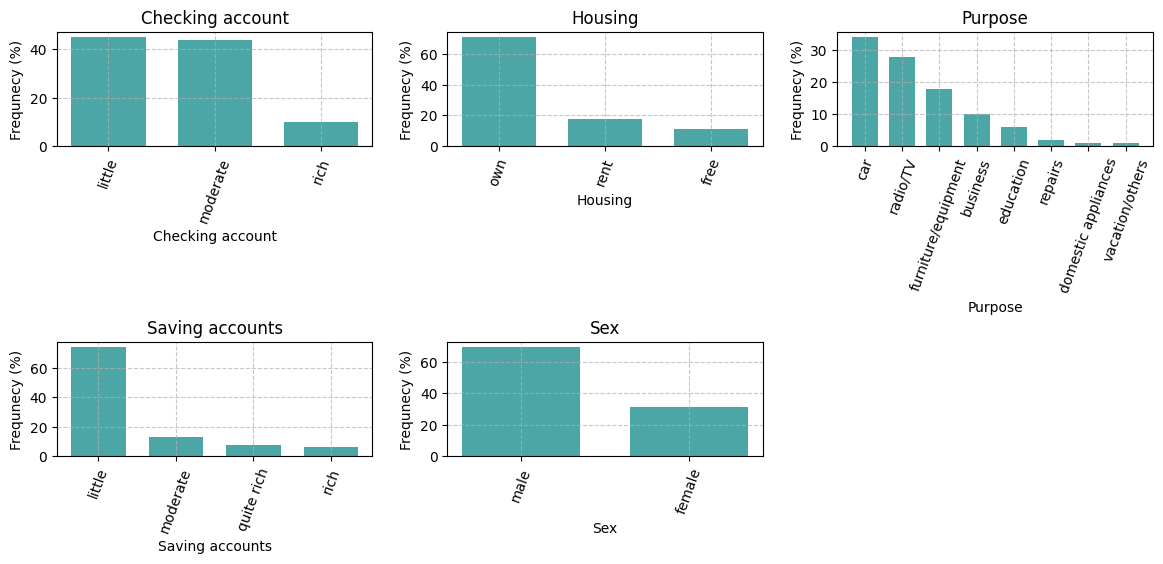

In [49]:
plot_bars(credit_data, categorical_vars, plots_per_row =3)

#### Checking link between features and target

##### Risk and age

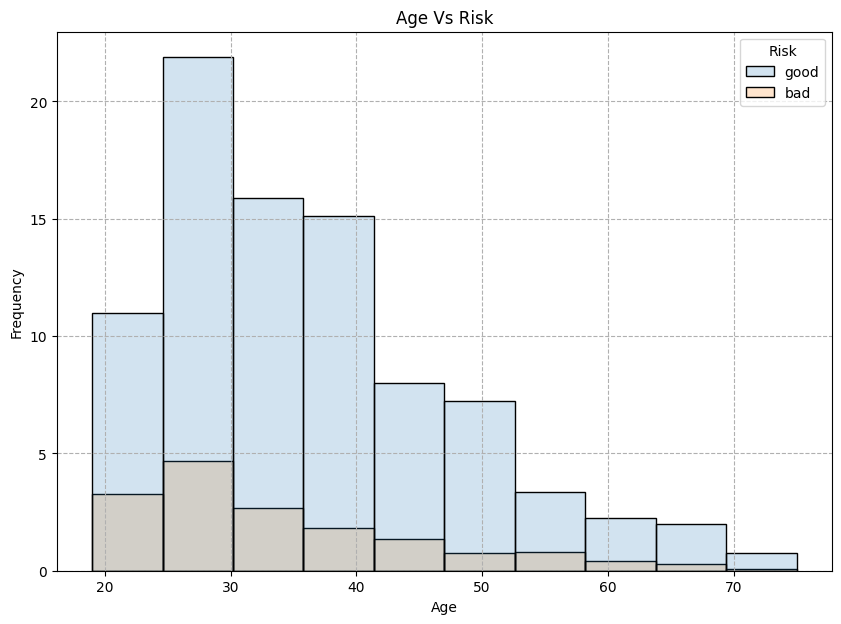

In [50]:
plot_target_vs_num_feature(credit_data, 
                               "Age",
                               num_bins=10)

##### Risk and Credit amount

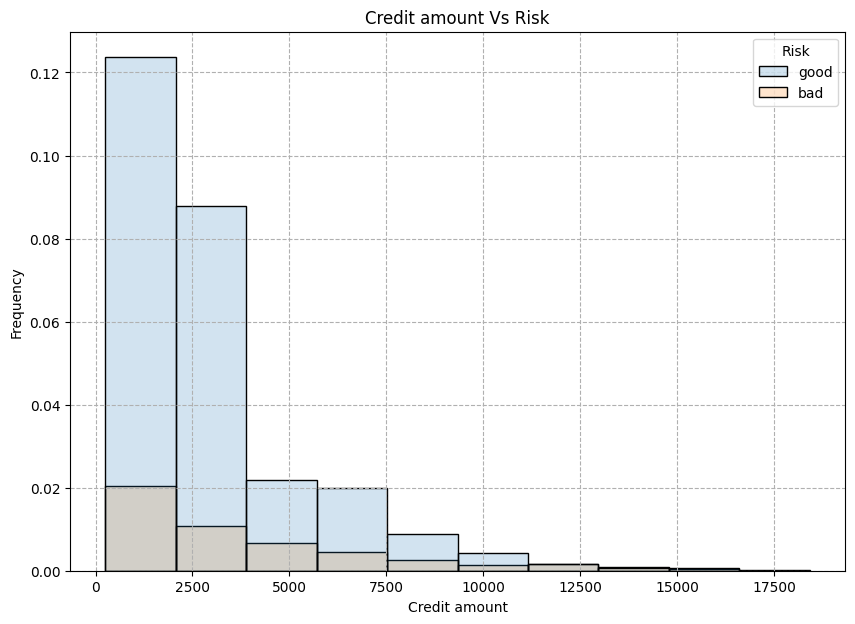

In [51]:
plot_target_vs_num_feature(credit_data, 
                               "Credit amount",
                               num_bins=10)

##### Risk and Duration

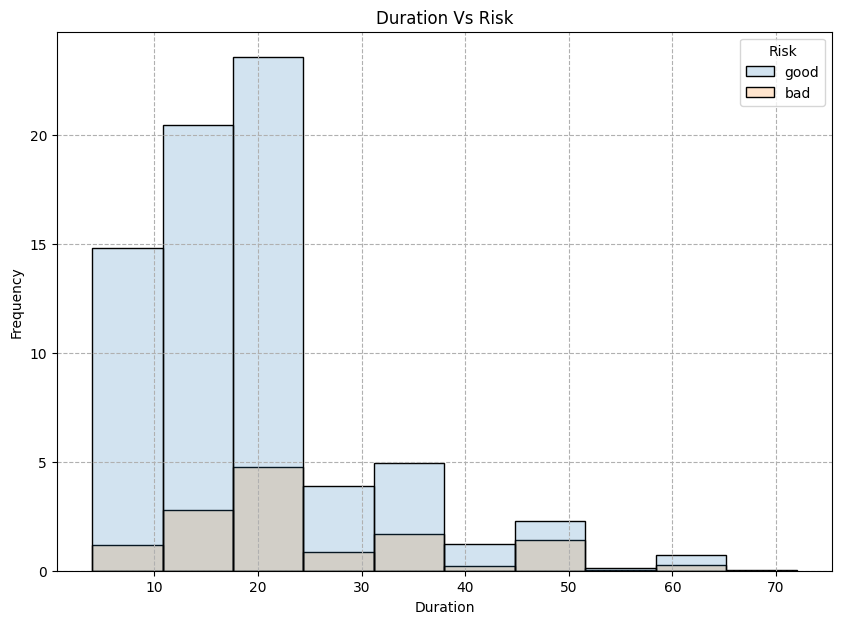

In [52]:
plot_target_vs_num_feature(credit_data, 
                               "Duration",
                               num_bins=10)

#### Job and Credit risk

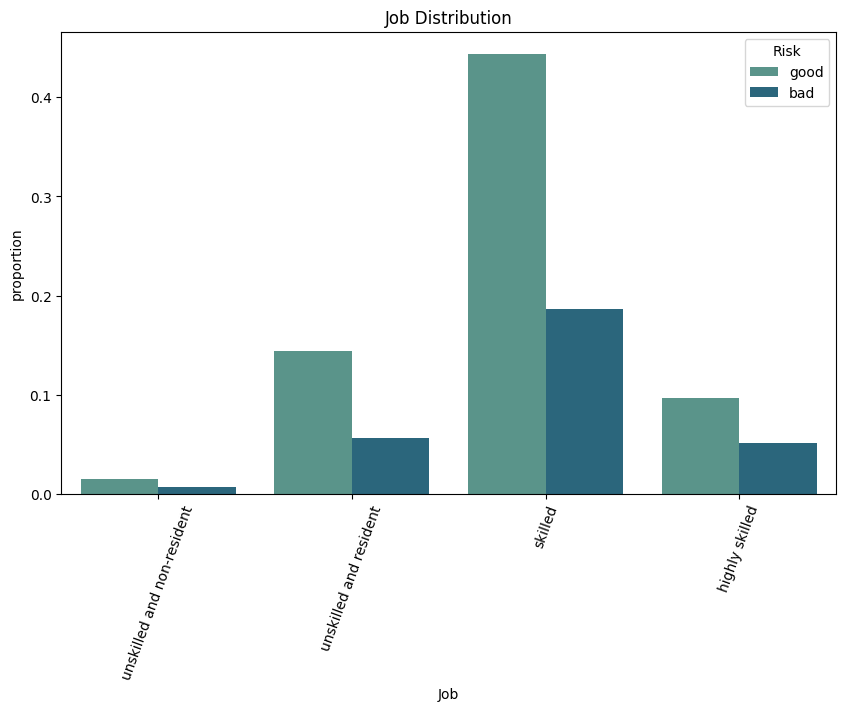

In [53]:
plt.figure(figsize=(10,6))
sns.countplot(data=credit_data, x="Job", hue="Risk", stat="proportion", palette="crest" )
plt.xticks([0,1,2,3],modalities_names, rotation=70)
plt.title("Job Distribution");

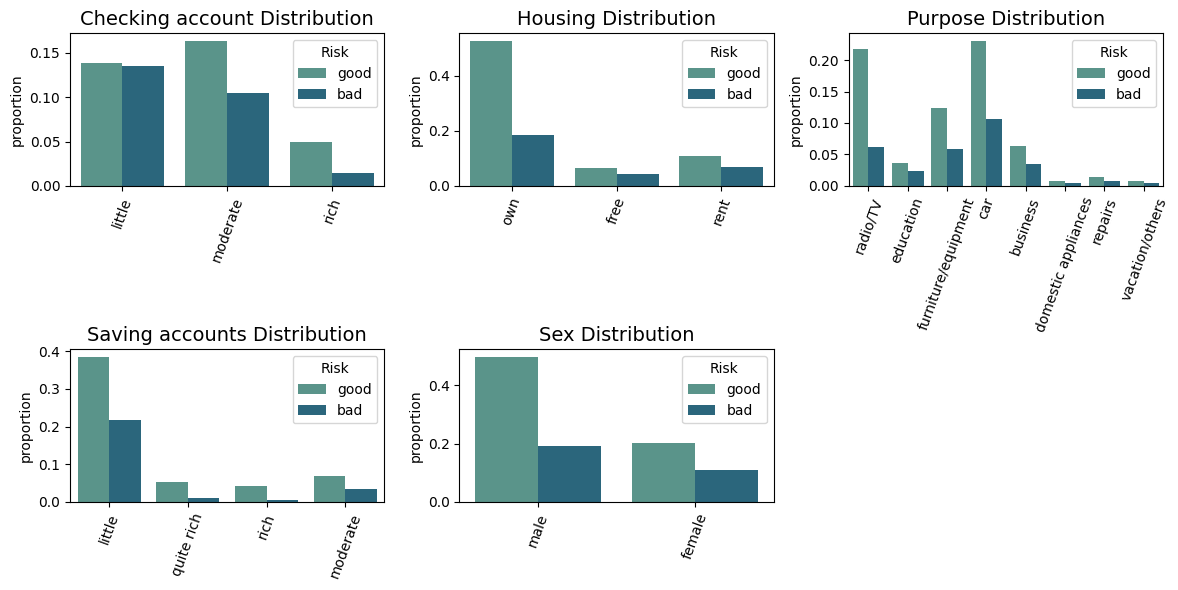

In [54]:
binary_plot_count(credit_data, categorical_vars, target="Risk", plots_per_row=3)

### Checking correlation between features

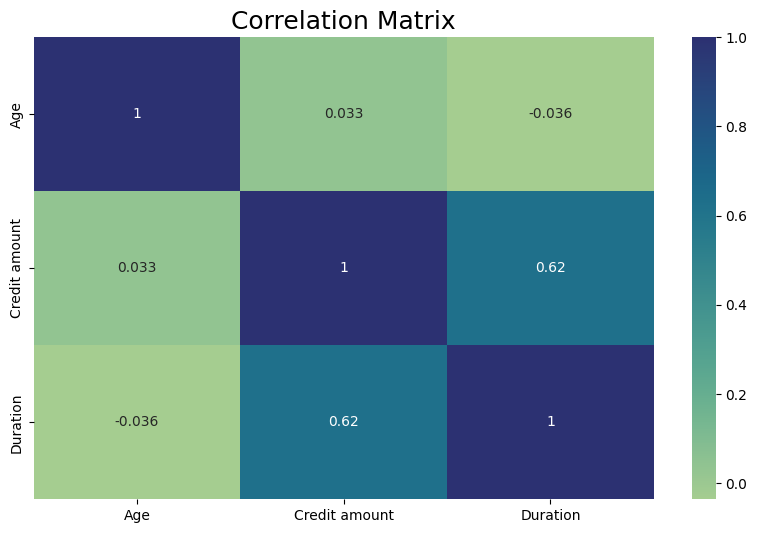

In [55]:
plt.figure(figsize=(10,6))
sns.heatmap(credit_data[numerical_vars].corr(), annot=True, cmap="crest")
plt.title('Correlation Matrix', fontsize=18);


### Data processing and feature engineering

From the previous section we identify two variables, saving account and checking account with missing values. Since they are all categorical variables, we fill this missing values with the mode of the respective variabale.

In [56]:
credit_data_processed = credit_data.copy()

- Saving account

In [57]:
mode_saving_account = credit_data_processed["Saving accounts"].mode()

In [58]:
credit_data_processed["Saving accounts"].fillna(mode_saving_account[0], inplace=True)

- Checking account

In [59]:
mode_checking_account = credit_data_processed["Checking account"].mode()

In [60]:
credit_data_processed["Checking account"].fillna(mode_checking_account[0], inplace=True)

In [61]:
credit_data_processed.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

- Treating outliers

Most of the numerical variables are not normally distributed, let use interquantile intervall for outliers detection.

- Identify numerical variables with outliers

In [62]:
def has_outliers(data:pd.DataFrame, feature:str):
    # Calculate the upper and lower limits
    Q1 = credit_data_processed[feature].quantile(0.25)
    Q3 = credit_data_processed[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(credit_data_processed[feature] >= upper)[0]
    lower_array = np.where(credit_data_processed[feature] <= lower)[0]

    num_outliers = len(upper_array) + len(lower_array)
    
    # # Removing the outliers
    # credit_data_processed.drop(index=upper_array, inplace=True)
    # credit_data_processed.drop(index=lower_array, inplace=True)
    return num_outliers, lower_array, upper_array, Q1, Q3

In [63]:
for var in numerical_vars:
    num_outliers,_,_,_,_ = has_outliers(credit_data, var)
    print(f"{var}: {num_outliers} outliers")

Age: 23 outliers
Credit amount: 72 outliers
Duration: 81 outliers


For the moment, let's try first to replace them by the upper and lower limits

In [64]:
def replace_outliers(data:pd.DataFrame, outlier_feature:str):
    _, lower_array, upper_array, Q1, Q3=has_outliers(data, outlier_feature)
    data.loc[lower_array, outlier_feature] = Q1
    data.loc[upper_array, outlier_feature] = Q3
    return data

In [65]:
for feature in numerical_vars:
    credit_data_processed = replace_outliers(credit_data_processed, feature)

### Label Encoding & One-Hot Encoding

In [66]:
cat_cols = [col for col in credit_data_processed.columns if credit_data_processed[col].dtypes == 'O']

In [67]:
cat_cols.remove("Risk")

In [71]:
# for feature in cat_cols:
#     credit_data_processed = credit_data_processed.merge(
#                             pd.get_dummies(credit_data_processed[feature],
#                              drop_first=True, prefix=feature.split(" ")[0]), 
#                             left_index=True, right_index=True)
credit_data_processed['Risk'] = credit_data_processed['Risk'].map({'good': 0, 'bad': 1})

In [68]:

# Create a label encoder
label_encoder = LabelEncoder()


# Apply label encoding to each categorical feature
encoded_features = {}
for feature in cat_cols:
    # Fit and transform the categorical feature
    credit_data_processed[feature] = label_encoder.fit_transform(credit_data_processed[feature])
    # Store the mapping
    encoded_features[feature] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    
# Display the encoded mappings for each categorical feature
for feature, mapping in encoded_features.items():
    print(f"Encoding for {feature}: {mapping}")




Encoding for Sex: {'female': 0, 'male': 1}
Encoding for Housing: {'free': 0, 'own': 1, 'rent': 2}
Encoding for Saving accounts: {'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3}
Encoding for Checking account: {'little': 0, 'moderate': 1, 'rich': 2}
Encoding for Purpose: {'business': 0, 'car': 1, 'domestic appliances': 2, 'education': 3, 'furniture/equipment': 4, 'radio/TV': 5, 'repairs': 6, 'vacation/others': 7}


In [72]:
credit_data_processed.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,42,1,2,1,0,0,1169.0,6,5,0
1,22,0,2,1,0,1,5951.0,24,5,1
2,49,1,1,1,0,0,2096.0,12,3,0
3,45,1,2,0,0,0,7882.0,24,4,0
4,53,1,2,0,0,0,4870.0,24,1,1


### Drop old variables

In [ ]:
# droplist=["Sex","Housing","Saving accounts","Checking account","Purpose"]

# credit_data_processed.drop(droplist, axis= 1, inplace = True)

In [69]:
# credit_data_processed.head()

#### Process Job feature

In [ ]:
# credit_data_processed['Job'].replace({0: "unskilled-non-resident", 
#                                       1: "unskilled-resident",
#                                       2: "skilled",
#                                       3:"highly skilled"
#                                       }, inplace=True)

In [ ]:
# credit_data_processed.head()

,Age,Job,Credit amount,Duration,Risk,Sex_male,Housing_own,Housing_rent,Saving_moderate,Saving_quite rich,Saving_rich,Checking_moderate,Checking_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,42,skilled,1169.0,6,0,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False
1,22,skilled,5951.0,24,1,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False
2,49,unskilled-resident,2096.0,12,0,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False
3,45,skilled,7882.0,24,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,53,skilled,4870.0,24,1,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [ ]:
# credit_data_processed = credit_data_processed.merge(
#                             pd.get_dummies(credit_data_processed["Job"],
#                              drop_first=True, prefix="Job"), 
#                             left_index=True, right_index=True)

In [ ]:
# credit_data_processed.drop("Job", axis= 1, inplace = True)


- Let standadize the numerical variables

In [76]:

transformer = ColumnTransformer(transformers=[
    ("robust_scaler", RobustScaler(), numerical_vars)
])
credit_data_processed.loc[:, numerical_vars] = transformer.fit_transform(credit_data_processed)

In [77]:
credit_data_processed.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0.600000,1,2,1,0,0,-0.441386,-1.0,5,0
1,-0.733333,0,2,1,0,1,1.393214,0.5,5,1
2,1.066667,1,1,1,0,0,-0.085745,-0.5,3,0
3,0.800000,1,2,0,0,0,2.134037,0.5,4,0
4,1.333333,1,2,0,0,0,0.978492,0.5,1,1


### Train test split of the data

In [78]:
features = credit_data_processed.drop("Risk", axis=1)
target = credit_data_processed["Risk"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)



#### Model 

### Rnadom forest with parameters tunning

In [84]:
rf = RandomForestClassifier(class_weight = {0: 1, 1: 3}, random_state=42)

In [85]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5,6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=1)
grid_search_rf.fit(X_train, y_train)

print("Best hyperparams:", grid_search_rf.best_params_)

best_rf = grid_search_rf.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyperparams: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [86]:
y_pred_rf = best_rf.predict(X_test)
y_pred_prob_rf = best_rf.predict_proba(X_test)[:, 1]


# ROC Curve
# plot_roc_curve(y_test, y_pred_prob_rf, "Random Forest")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       141
           1       0.39      0.41      0.40        59

    accuracy                           0.64       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.64      0.64      0.64       200



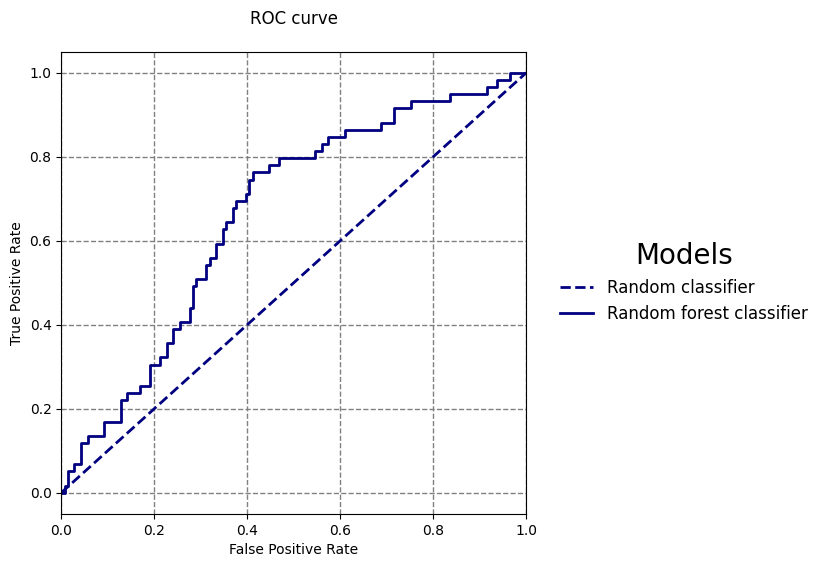

In [87]:
plot_ROC_curve(best_rf,["Random classifier", "Random forest classifier"], X_test, y_test, class_index=1)

### Metrics


Classifier Performance: Random Forest

Accuracy: 0.635
     TPR: 0.407
     TNR: 0.730
     FPR: 0.270


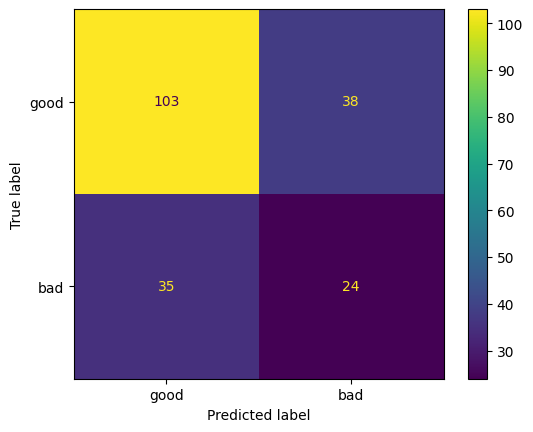

In [88]:
print_metrics(best_rf, X_test, y_test, printCM=True, title="Classifier Performance: Random Forest")

### Features importances

In [105]:
best_rf.feature_importances_

array([0.22695655, 0.03235428, 0.04259013, 0.05282566, 0.05529776,
       0.04531558, 0.26957385, 0.17158348, 0.10350272])

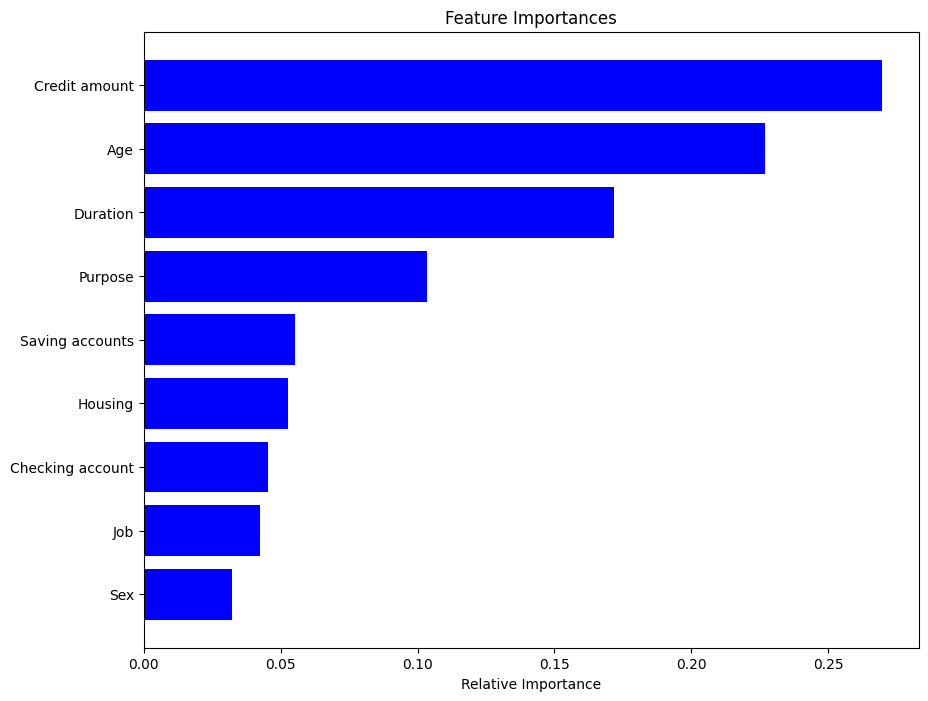

In [110]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [credit_data_processed.columns[:-1][i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Subset the processed data for most important features

In [111]:
credit_data_sub = credit_data_processed[["Credit amount", "Age", "Duration", "Purpose", "Risk"]]

#### Rename credit amount column

In [144]:
credit_data_sub = credit_data_sub.rename(columns={"Credit amount":"Credit_amount"})

In [145]:
features_sub = credit_data_sub.drop("Risk", axis=1)
target_sub = credit_data_sub["Risk"]
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(features_sub, target_sub, test_size=0.2, random_state=42)



In [146]:
rf = RandomForestClassifier(class_weight = {0: 1, 1: 3}, random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5,6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=1)
grid_search_rf.fit(X_train_sub, y_train_sub)

print("Best hyperparams:", grid_search_rf.best_params_)

best_rf = grid_search_rf.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyperparams: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}



Classifier Performance: Random Forest

Accuracy: 0.655
     TPR: 0.644
     TNR: 0.660
     FPR: 0.340


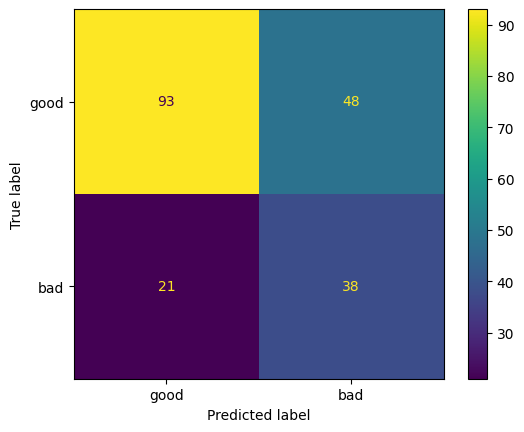

In [147]:
print_metrics(best_rf, X_test_sub, y_test_sub, printCM=True, title="Classifier Performance: Random Forest")

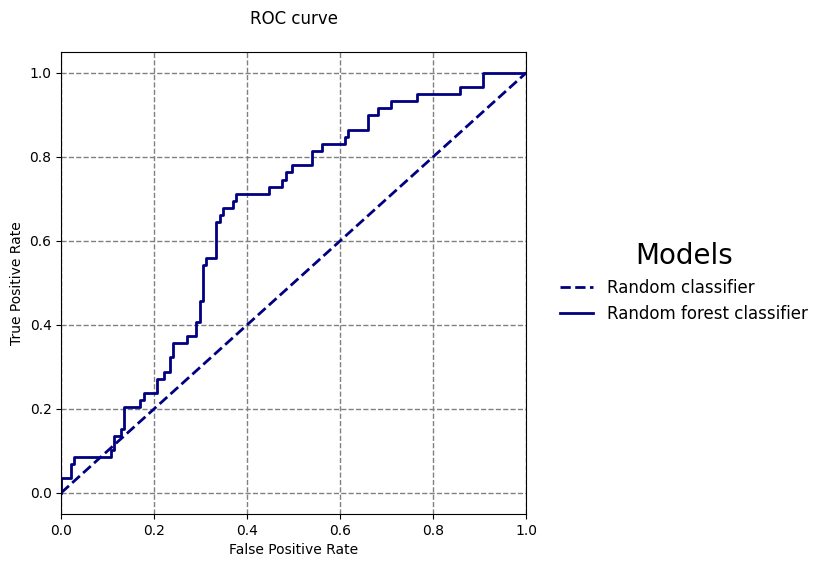

In [148]:
plot_ROC_curve(best_rf,["Random classifier", "Random forest classifier"], X_test_sub, y_test_sub, class_index=1)

In [149]:
print(f"AUC:{round(roc_auc_score(y_test_sub, best_rf.predict(X_test_sub)),4)}")

AUC:0.6518


## Save the model

In [150]:
with open('best_rf.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
